In [1]:
import numpy as np, cv2, matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [44]:
# usando todo en cm
res = 1025
l = 5
x = 10
a = 2.5e-3 # e-2 for 0.25mm
I0 = 1         # fuente: de los deseos
lmd = 5.32e-5

vec = np.linspace(-l/2, l/2, res)
Y, Z = np.meshgrid(vec, vec)

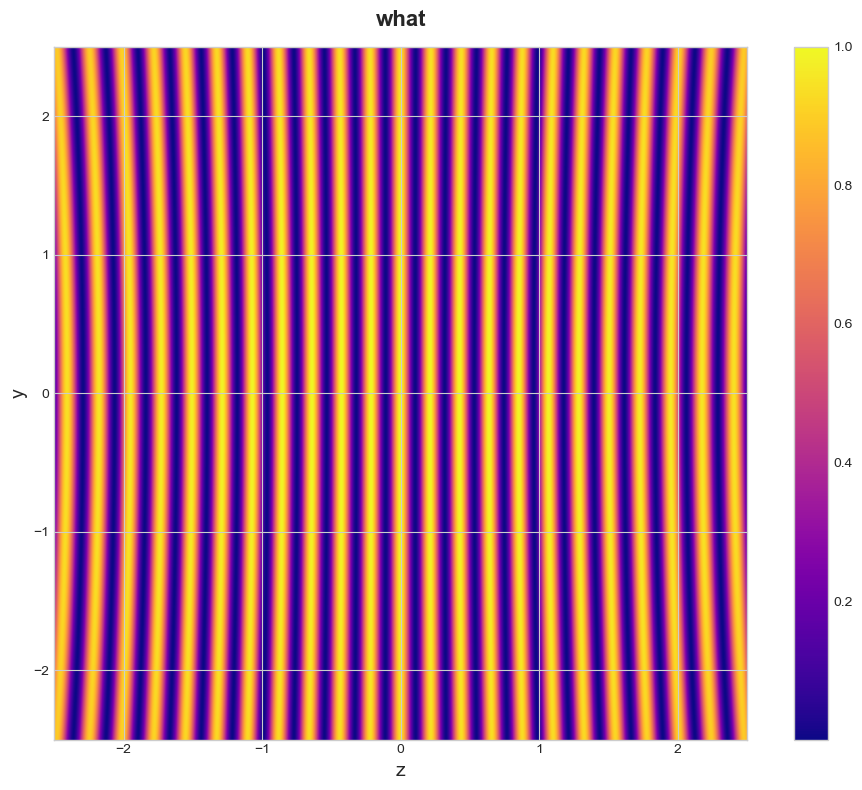

In [103]:
# matrices s1 y s2
s1 = np.sqrt(x**2 + Y**2 + (Z - a/2)**2)
s2 = np.sqrt(x**2 + Y**2 + (Z + a/2)**2)

# intensidad
I1 = I0/(s1**2)
I2 = I0/(s2**2)
I = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(2 * np.pi * (s2-s1) / lmd)
Inorm = I/np.max(I)

# graph
plt.style.use('seaborn-v0_8-whitegrid')  
fig, ax = plt.subplots(figsize=(10, 8))

# capture the QuadContourSet returned by contourf and pass it to colorbar
cs = ax.imshow(Inorm, extent=(-l/2, l/2, -l/2, l/2), cmap='plasma')
ax.set_ylabel('y', fontsize=14)
ax.set_xlabel('z', fontsize=14)
ax.set_title('what', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.colorbar(cs, ax=ax)
# ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
# plt.savefig('Srel.png', dpi=300)
plt.show()

Best-fit a = 0.488 mm


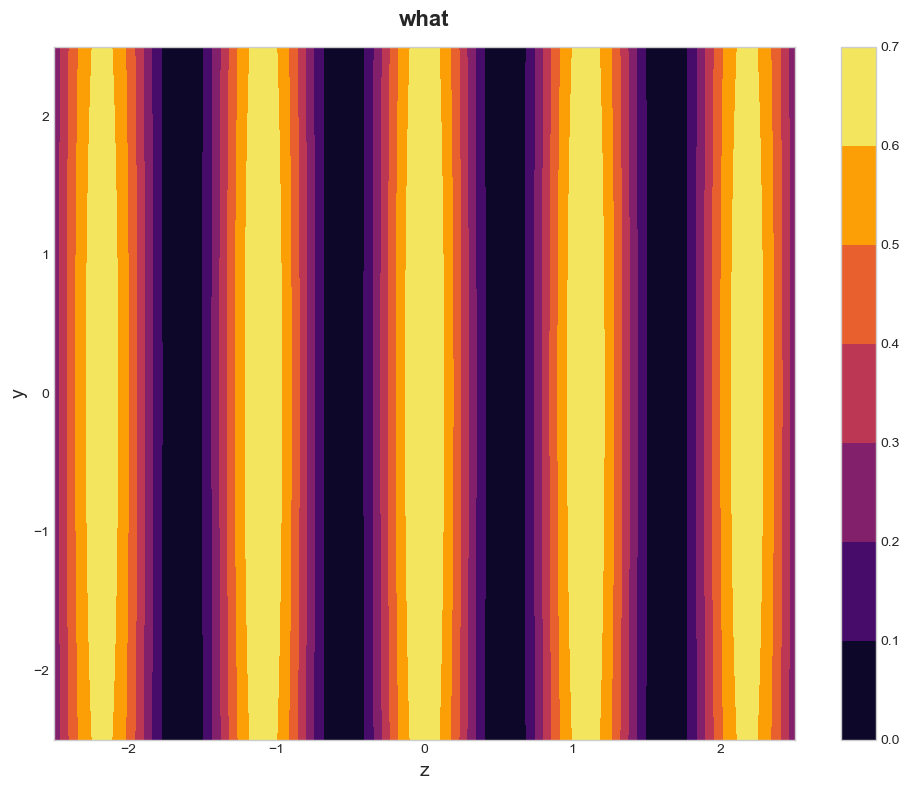

In [4]:
# mas constantes de nuevo en cm
lmd = 5.32e-5
x = 10
I0 = 1         # fuente: de los deseos
L = 5

fPar = cv2.imread('data/FranjasParalelas.tif', cv2.IMREAD_GRAYSCALE).astype(float)
Iexp = fPar/np.max(fPar)

Ny, Nz = fPar.shape  # dimensiones de la imagen
y = np.linspace(-L/2, L/2, Ny)
z = np.linspace(-L/2, L/2, Nz)
Y, Z = np.meshgrid(y, z, indexing='ij')

def Imod(Y, Z, a, I0=I0, x=x, lmd=lmd):
    s1 = np.sqrt(x**2 + Y**2 + (Z - a/2)**2)
    s2 = np.sqrt(x**2 + Y**2 + (Z + a/2)**2)
    I1 = I0/(s1**2)
    I2 = I0/(s2**2)
    return I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(2 * np.pi * a * Z / (lmd * x) )

# flatten data for curve_fit
Z_flat = Z.ravel()
Y_flat = Y.ravel()
I_flat = Iexp.ravel()

def I_fit(coords, a, scale):
    Y, Z = coords
    return scale * Imod(Y, Z, a).ravel()

def I_calc(coords, a, scale):
    Y, Z = coords
    return scale * Imod(Y, Z, a)

popt, pcov = curve_fit(I_fit, (Y_flat, Z_flat), I_flat, p0=[0.00025, 1.0])
a_fit, scale_fit = popt

print(f"Best-fit a = {a_fit*1e3:.3f} mm")

# graph
plt.style.use('seaborn-v0_8-whitegrid')  
fig, ax = plt.subplots(figsize=(10, 8))
# capture the QuadContourSet returned by contourf and pass it to colorbar
cs = ax.contourf(Z, Y, I_calc((Y,Z), *popt), extent=(-L/2, L/2, -L/2, L/2), cmap='inferno')
ax.set_ylabel('y', fontsize=14)
ax.set_xlabel('z', fontsize=14)
ax.set_title('what', fontsize=16, fontweight='bold', pad=15)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.colorbar(cs, ax=ax)
ax.grid(False)
plt.tight_layout()
# plt.savefig('polarized.png', dpi=300)
plt.show()

In [ ]:
a_test = 0.488e-3  # 0.25 mm
I_theo = Imod(Y, Z, a_test)
I_theo /= np.max(I_theo)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Experimental
im0 = axs[0].imshow(Iexp, extent=[-L/2, L/2, -L/2*100, L/2*100],
                    origin='upper', cmap='inferno')
axs[0].set_title("Experimental pattern")
axs[0].set_xlabel("z (cm)")
axs[0].set_ylabel("y (cm)")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label="Normalized intensity")

# Theoretical
im1 = axs[1].imshow(I_theo, extent=[-L/2*100, L/2*100, -L/2*100, L/2*100],
                    origin='upper', cmap='inferno')
axs[1].set_title(f"Theoretical pattern (a = {a_test*1e3:.2f} mm)")
axs[1].set_xlabel("z (cm)")
axs[1].set_ylabel("y (cm)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label="Normalized intensity")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 